In [21]:
## Extract files

import os
from zipfile import ZipFile

if 'train.csv' not in os.listdir():
    ZipFile('titanic.zip','r').extractall()

In [2]:
## Load data

import pandas as pd

df_train = pd.read_csv('train.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [23]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
## Create validation set

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train.loc[:, df_train.columns != 'Survived'],df_train['Survived'], test_size=0.2, random_state=42, stratify=df_train['Survived'])

In [25]:
## Check null values

print('Total entries: ', len(df_train))
X_train.isnull().sum()

Total entries:  891


PassengerId      0
Pclass           0
Name             0
Sex              0
Age            137
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
dtype: int64

In [109]:
## Estimate Titles (for Age estimation)

title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles(row):
    return title_dictionary[row['Name'].split(', ')[1].split('.')[0]]

X_train['Titles'] = X_train.apply(get_titles, axis=1)

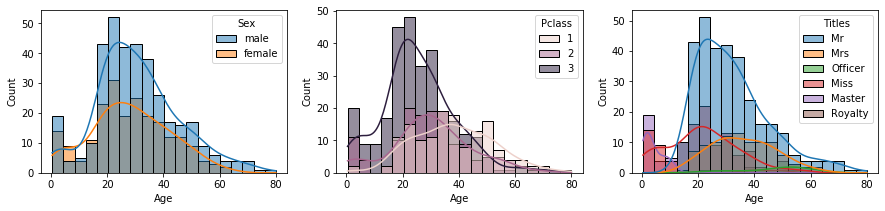

In [110]:
## Check Age correlations

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sns.histplot(data=X_train,x='Age',kde=True, bins=20,hue='Sex')
plt.subplot(1,3,2)
sns.histplot(data=X_train,x='Age',kde=True, bins=20,hue='Pclass')
plt.subplot(1,3,3)
sns.histplot(data=X_train,x='Age',kde=True, bins=20,hue='Titles')
plt.show()

In [141]:
## Estimate Age

def estimate_age(df):
    median_by_titles = df.groupby('Titles')['Age'].median()
    median_by_gender = df.groupby('Sex')['Age'].median()
    median_by_pclass = df.groupby('Pclass')['Age'].median()

    return pd.Series(data=((median_by_titles[df['Titles']].values + median_by_gender[df['Sex']].values + median_by_pclass[df['Pclass']].values)//3), index=df.index)

X_train['Age'].fillna(estimate_age(X_train), axis=0, inplace=True)
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
Titles           0
dtype: int64

In [154]:
## Check embarked missing rows

display(X_train[X_train['Embarked'].isnull()])
display(X_train[X_train['Ticket'] == '113572'])
display(X_train[X_train['Cabin'] == 'B28'])

print(X_train['Embarked'].value_counts())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss


S    516
C    139
Q     55
Name: Embarked, dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Ticket_n,Surname_n_repeated
692,693,3,"Lam, Mr. Ali",male,27.0,0,0,1601,56.4958,NaN,S,Mr,1601,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.0,0,0,239854,0.0000,NaN,S,Mr,239854,1
527,528,1,"Farthing, Mr. John",male,32.0,0,0,PC 17483,221.7792,C95,S,Mr,17483,1


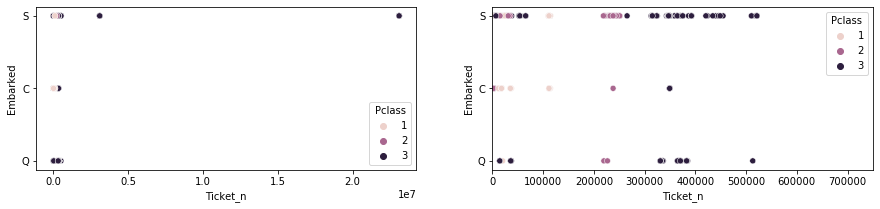

In [201]:
## Check tickets

import regex as re

def fill_ticket_n(row):
    try:
        return int(re.sub("[^0-9]","",row['Ticket']))
    except:
        return int(0)

X_train['Ticket_n'] = X_train.apply(fill_ticket_n,axis=1)
display(X_train.head(3))

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.scatterplot(data=X_train,x='Ticket_n',y='Embarked', hue='Pclass')
plt.subplot(1,2,2)
sns.scatterplot(data=X_train,x='Ticket_n',y='Embarked', hue='Pclass')
plt.axis(xmin=0, xmax=750000)
plt.show()

In [189]:
## Replacing Embarked missing rows by 'S' (hardcoded)

X_train['Embarked'].fillna('S', inplace=True)

In [199]:
## Feature Engineering: creating Surname_n_repeated feature

Surnames = X_train['Name'].apply(lambda x:x.split(', ')[0])
print(Surnames.value_counts())
X_train['Surname_n_repeated'] = Surnames.apply(lambda x:Surnames.value_counts()[x])
X_train.head(2)

Andersson    7
Panula       5
Skoog        5
Johnson      5
Sage         5
            ..
Cook         1
Eustis       1
O'Leary      1
Collander    1
Homer        1
Name: Name, Length: 557, dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Ticket_n,Surname_n_repeated
692,693,3,"Lam, Mr. Ali",male,27.0,0,0,1601,56.4958,NaN,S,Mr,1601,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.0,0,0,239854,0.0000,NaN,S,Mr,239854,1


In [4]:
## Transformation pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class PreprocessAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        # no *args or ** kargs
        self.title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir" : "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess":"Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr" : "Mr",
            "Mrs" : "Mrs",
            "Miss" : "Miss",
            "Master" : "Master",
            "Lady" : "Royalty"
        }
        self.median_by_titles = pd.Series()
        self.median_by_gender = pd.Series()
        self.median_by_pclass = pd.Series()
        self.Surnames = pd.Series()
    def fit(self, X, y = None):
        def get_titles(row):
            return self.title_dictionary[row['Name'].split(', ')[1].split('.')[0]]
        X['Titles'] = X.apply(get_titles, axis=1)
        self.median_by_titles = X.groupby('Titles')['Age'].median()
        # self.median_by_titles['Other'] = X['Age'].median()
        # display(self.median_by_titles)
        self.median_by_gender = X.groupby('Sex')['Age'].median()
        self.median_by_pclass = X.groupby('Pclass')['Age'].median()
        Surnames = X['Name'].apply(lambda x:x.split(', ')[0])
        self.surnames_n_repeated = Surnames.value_counts()
        return self # nothing else to do 
    def transform(self, X):
        def get_titles(row):
            try:
                return self.title_dictionary[row['Name'].split(', ')[1].split('.')[0]]
            except:
                if row['Sex'] == 'male':
                    return "Mr"
                else:
                    return "Miss"
        X['Titles'] = X.apply(get_titles, axis=1)

        def estimate_age(df):
            return pd.Series(data=((self.median_by_titles[df['Titles']].values + self.median_by_gender[df['Sex']].values + self.median_by_pclass[df['Pclass']].values)//3), index=df.index)
        X['Age'].fillna(estimate_age(X), axis=0, inplace=True)

        def fill_ticket_n(row):
            import regex as re
            try:
                return int(re.sub("[^0-9]","",row['Ticket']))
            except:
                return int(0)
        X['Ticket_n'] = X.apply(fill_ticket_n,axis=1)

        X['Embarked'].fillna('S', inplace=True)

        def check_surname(row):
            try:
                return self.surnames_n_repeated[row]
            except:
                return 0
        Surnames = X['Name'].apply(lambda x:x.split(', ')[0])
        X['Surname_n_repeated'] = Surnames.apply(check_surname)

        # display(X)
        return X

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Get rid of possible null values
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ("one_hot_enconder", OneHotEncoder(drop='first'))
])

combined_pipeline = ColumnTransformer([
    ("num", num_pipeline, ['Age','SibSp','Parch','Fare','Ticket_n','Surname_n_repeated']),
    ("cat", cat_pipeline, ['Pclass','Sex','Embarked','Titles']),
])

full_pipeline = Pipeline([
    ("preprocessing", PreprocessAttributes()),
    ("combined", combined_pipeline),
])

X_train_prep = full_pipeline.fit_transform(X_train)
# print(X_train_prep[0])

X_val_prep = full_pipeline.transform(X_val)

In [112]:
# ## Model building and fine tuning: Grid Search

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# # for param in model.get_params().keys():
# #     print(param)

# names = [
#     "Random Forest Classifier",    
#     "Logistic Regression",
# ]

# classifiers = [
#     RandomForestClassifier(random_state=42),
#     LogisticRegression(random_state=42)
# ]

# # model = model.fit(X_train_prep,y_train)

# parameters = [
#     { 
#         "clf__n_estimators": [30, 50, 100, 200, 500], 
#         "clf__max_leaf_nodes": [8, 16, 32]
#     },
#     {
#         "clf__penalty": ['l1','l2','elasticnet','none'],
#         "clf__C": np.logspace(-4,4,20),
#         "clf__solver": ['lbfgs','newton-cg','liblinear','sag','saga'],
#         "clf__max_iter": [100,1000,2500,5000]
#     }
# ]

# best_score = 0
# best_estimator = None

# for name, classifier, params in zip(names, classifiers, parameters):
#     model = Pipeline([
#         # ('preprocesing', full_pipeline),
#         ('clf', classifier),
#     ])
#     gs_clf = GridSearchCV(model, param_grid=params, n_jobs=-2, verbose=False, cv=3)
#     clf = gs_clf.fit(X_train_prep, y_train)
#     predictions = clf.predict(X_val_prep)
#     score = precision_score(y_val, predictions)
#     # score = clf.score(X_val_prep, y_val)
#     print("{} score: {}, params: {}".format(name, score, clf.best_params_))
#     if score > best_score:
#         best_score = score
#         best_estimator = clf

Random Forest Classifier score: 0.8245614035087719, params: {'clf__max_leaf_nodes': 32, 'clf__n_estimators': 500}
Logistic Regression score: 0.7794117647058824, params: {'clf__C': 1.623776739188721, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [33]:
## Model building and fine tuning: Grid Search

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
# from sklearn.model_selection import RandomizedSearchCV

def execute_pipeline(features,labels, search_space=[
                    {"classifier": [LogisticRegression(random_state=42)],
                    "classifier__penalty": ['l2','l1'],
                    "classifier__C": np.logspace(0, 4, 10)
                    },
                    {"classifier": [LogisticRegression(random_state=42)],
                    "classifier__penalty": ['l2'],
                    "classifier__C": np.logspace(0, 4, 10),
                    "classifier__solver":['newton-cg','saga','sag','liblinear'] ##This solvers don't allow L1 penalty
                    },
                    {"classifier": [RandomForestClassifier(random_state=42)],
                    "classifier__n_estimators": [10,100,500,1000],
                    "classifier__max_depth":[5,8,15,25,30,None],
                    "classifier__min_samples_leaf":[1,2,5,10,15,100],
                    "classifier__max_leaf_nodes": [8,16,32]}
                 ], 
                 cv=5, verbose=1, n_jobs=-1):
    
    pipe = Pipeline([("classifier", RandomForestClassifier())])
    
    gridsearch = GridSearchCV(pipe, search_space, cv=cv, verbose=verbose,n_jobs=n_jobs) # Fit grid search
    best_model = gridsearch.fit(features, labels)
    print(best_model.best_estimator_)
    print("The mean accuracy of the model is:",best_model.score(features, labels))

    return best_model

best_estimator = execute_pipeline(X_train_prep,y_train)

Fitting 5 folds for each of 492 candidates, totalling 2460 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 559 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1658 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:  3.6min
Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=32, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,

In [41]:
## Evaluate on validation data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

model = best_estimator

predictions = model.predict(X_val_prep)
print(confusion_matrix(y_val, predictions,labels=[1,0]))
print('Precision: ', precision_score(y_val, predictions))
print('Recall: ', recall_score(y_val, predictions))
print('F1: ', f1_score(y_val, predictions))


[[ 47  22]
 [ 10 100]]
Precision:  0.8245614035087719
Recall:  0.6811594202898551
F1:  0.746031746031746


In [114]:
## Check dummies

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_prep, y_train)
predictions_dummy = dummy_clf.predict(X_val_prep)

print(dummy_clf.score(X_val_prep,y_val))
print(confusion_matrix(y_val, predictions_dummy,labels=[1,0]))
print('Precision: ', precision_score(y_val, predictions_dummy))
print('Recall: ', recall_score(y_val, predictions_dummy))
print('F1: ', f1_score(y_val, predictions_dummy))


0.6145251396648045
[[  0  69]
 [  0 110]]
Precision:  0.0
Recall:  0.0
F1:  0.0


In [43]:
import pandas as pd
import copy

df_train = pd.read_csv('train.csv')
X_train_all, y_train_all = df_train.loc[:, df_train.columns != 'Survived'], df_train['Survived']
X_train_all_prep = full_pipeline.transform(X_train_all)

model = copy.deepcopy(best_estimator.best_estimator_)
model = model.fit(X_train_all_prep, y_train_all)

X_test = pd.read_csv('test.csv')

X_test_prep = full_pipeline.transform(X_test)
X_test['Survived'] = model.predict(X_test_prep)
display(X_test)

X_test[['PassengerId','Survived']].to_csv('submission.csv',index=False)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Ticket_n,Surname_n_repeated,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,330911,3,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,363272,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,240276,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,315154,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,3101298,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,NaN,S,Mr,53236,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Miss,17758,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,3101262,0,0
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,NaN,S,Mr,359309,0,0
